In [1]:
# IMPORTS
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import seaborn as sns
import pandas_market_calendars as cal
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, accuracy_score

# HYPERPARAMETERS
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# EXTRA ARGUMENTS
FastRun=False #if true distribution and correlation plots are not generated
pd.set_option('display.max_columns',None) #shows all columns using df.tail() or df.head()

In [2]:
# ONLINE DOWNLOAD 
df = yf.download(tickers = '^GSPC', start = '2000-1-1',end = '2018-12-31')
df.to_csv('S&P500.csv')

# OFFLINE LOAD
#df = pd.read_csv("S&P500.csv",index_col='Date')
#df.index = pd.to_datetime(df.index)

# FEATURES
1) Remove Outliers
2) Add Technical Indicators
3) Add colums with dates
4) Add lags
5) Add targets (train results)
6) Remove N/A 

## OUTLIERS
* Using boxplot to remove outliers
* Only Volume has siginificant number of outliers
* Why removing outliers? We want to train our model on typical behaviour, unexpected changes worsten testing results

In [3]:
def outliers(df,col):
    """
    Remove outliers in dataframe df at colum col
    """
    Q1 =  df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print("Outliers "+ str(col),df[(df[col] < Q1-1.5*IQR ) | (df[col] > Q3+1.5*IQR)][col])
    df = df[(df[col] > Q1-1.5*IQR ) & (df[col] < Q3+1.5*IQR)]
    return df

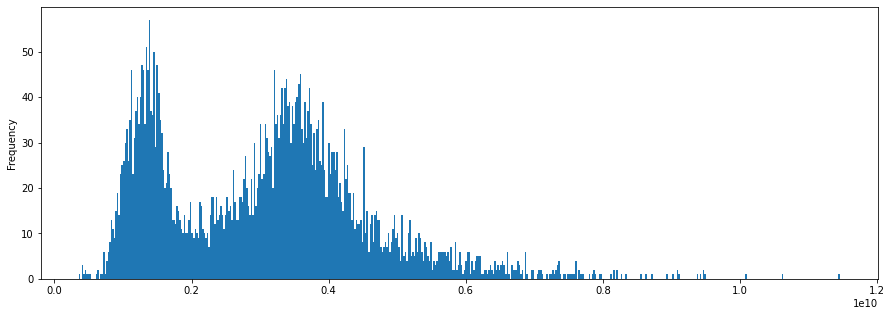

In [4]:
# HISTOGRAM
df['Volume'].plot(kind='hist', bins=500,figsize=(15, 5))
plt.savefig('Graphs/Outliers_Histogram.pdf')

Outliers Volume Date
2008-09-15     8279510000
2008-09-16     9459830000
2008-09-17     9431870000
2008-09-18    10082690000
2008-09-19     9387170000
2008-10-06     7956020000
2008-10-08     8716330000
2008-10-10    11456230000
2008-10-14     8161990000
2008-10-16     7984500000
2008-11-13     7849120000
2008-11-20     9093740000
2008-11-21     9495900000
2008-11-24     7879440000
2009-01-15     7807350000
2009-02-20     8210590000
2009-02-25     7483640000
2009-02-26     7599970000
2009-02-27     8926480000
2009-03-02     7868290000
2009-03-03     7583230000
2009-03-04     7673620000
2009-03-05     7507250000
2009-03-10     8618330000
2009-03-16     7883540000
2009-03-18     9098450000
2009-03-19     9033870000
2009-03-20     7643720000
2009-03-23     7715770000
2009-03-25     7687180000
2009-04-02     7542810000
2009-04-09     7600710000
2009-04-14     7569840000
2009-04-21     7436490000
2009-05-06     8555040000
2009-05-07     9120100000
2009-05-08     8163280000
2009-05-20     82

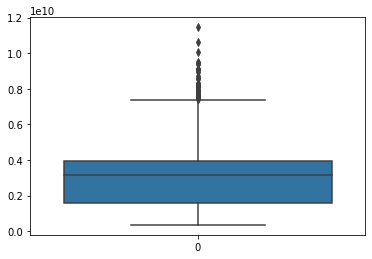

In [5]:
# BOXPLOT
sns.boxplot(data=df['Volume'])
plt.savefig('Graphs/Outliers_Boxplot.pdf')
df = outliers(df,'Volume')

## TECHNICAL INDICATORS
* Importance of each technical indicator is ploted after training the model
* ML models can find some patterns between TA and trading volume, although it is very implausible
* Only the most important features are used
* Why? It would be hard to understand the behaviour of our model with so many features

In [6]:
df['VolumeDiff'] = df['Volume']-df['Volume'].shift(1)
df['Average'] = df.ta.midprice(length=1) #midprice
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi(length=14)
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA140'] = df.ta.sma(length=140)
df["CCI"] = ta.cci(df.High, df.Low, df.Close, length=16)
df["AO"] = ta.ao(df.High, df.Low)
df["MOM"] = ta.mom(df.Close, length=16)
df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=16)
df["BOP"] = ta.bop(df.Open, df.High, df.Low, df.Close, length=16)
df["RVI"] = ta.rvi(df.Close)
df["WPR"] = ta.willr(df.High, df.Low, df.Close, length=16)
df = pd.concat([df,ta.macd(df.Close, length = 16)],axis=1, join='inner')
df = pd.concat([df,ta.dm(df.High, df.Low, length=16)],axis=1, join='inner')
df = pd.concat([df,ta.stochrsi(df.Close, length=16)],axis=1, join='inner')
df = pd.concat([df,ta.stoch(df.High, df.Low, df.Close)],axis=1, join='inner')

## DATES
* There are no occuring patterns, therefore adding dates features should not be useful
* To prove the hypothesis we check it with the feature importance after training the model

In [7]:
def add_dates(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Dayofweek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Dayofmonth'] = df.index.day
    df['Quarter'] = df.index.quarter
    return df

In [8]:
df = add_dates(df)

## MARKET CALENDAR
* Add number of hours when market is opened
* Why? Less hours means smaller volume
* Nasdaq and NYSE have same opening hours (that is where most of S&P500 companies are traded)
* On average there are 2 times less trades when the opening hours are less than typical 6.5h

In [9]:
nyse = cal.get_calendar('NYSE')
pd_nyse = nyse.schedule(start_date = '2000-1-1',end_date = '2018-12-31')
df['Opening Hours NYSE'] = (pd_nyse.market_close - pd_nyse.market_open) / pd.Timedelta(hours=1)
print("Average Trading Volume: ",df['Volume'].mean())
print("Average During Holiday: ",df[df['Opening Hours NYSE'] < 6.5]['Volume'].mean())

Average Trading Volume:  3023395802.076711
Average During Holiday:  1364053000.0


## ADD LAGS
* Disclaimer: This is WIP
* No monthly/weekly/hourly occuring patterns as for exampel in power consumption
* What if there are some historically reocurring patterns?
    * What if the market behaves similarly as week/month/halfyear/year ago?
    * Well, then use unsupervised ML, not this :D
* No reason this should be helpful, since the ML models check for the reocurring patterns themselves
* Check the hypothesis in features importance, if these features are useful, come back and dive deep into it
* TODO: Investigate the reocurring patterns only with no other features (using unsupervised ML like DBSCAN?)

In [10]:
def add_lags(df):
    """
    Add historical data do dataframe df
    """
    df['Volume-Y/2'] = df['Volume'].shift(126) #252 trading days per year
    df['Volume-M'] = df['Volume'].shift(21)
    df['Volume-W'] = df['Volume'].shift(5)
    df['Volume-D'] = df['Volume'].shift(1)
    df['VolumeDiff-Y/2'] = df['VolumeDiff'].shift(126)
    df['VolumeDiff-M'] = df['VolumeDiff'].shift(21)
    df['VolumeDiff-W'] = df['VolumeDiff'].shift(5)
    df['VolumeDiff-D'] = df['VolumeDiff'].shift(1)
    return df

In [11]:
df = add_lags(df)

## TARGETS
   We are trying to predict three targets:
1) Target Volume: The trading volume for the next day, the one we want to predict
    * It will not be that easy :)
2) Target VolumeDiff: Difference between today volume and tomorrow
    * Why VolumeDiff? While predicting the volume, the ML will likely train to just predict the volume from previous day
3) TargetClass: 0 if volume in the next day decreases, 1 if increases
    * Why TargetClass? Predicting the exact volume difference still be too complex, what probability could be achieved if jsut predicting the rise or fall?

In [12]:
df['Target_Volume'] = df['Volume'].shift(-1)
df['Target_VolumeDiff'] = df['Volume'].shift(-1)-df['Volume']
df['Target_VolumeClass'] = [1 if df.Target_VolumeDiff[i]>0 else 0 for i in range(len(df))] #TODO: pridat komplexnejsi categorizaci

## DROP N/A VALUES
* Having N/A values in our dataset will make it harder to train the ML
* All N/A values are in the first half year of our training data (moving average and lags) and the very last day (missing target)
* Since we have 15 years of training data, missing half a year will probably not make such difference
* Another TODO: Does the model even with some N/A values in first half of the year predict better results?

In [13]:
# DROP THE NA VALUES
print(df.isna().sum())
df = df.dropna()
#df.reset_index(drop=True, inplace=True)
#df.reset_index('Date')
#print(*df.columns.tolist(), sep='\n')
#df.tail()

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
VolumeDiff               0
Average                  0
ATR                      3
RSI                      1
MA40                    26
MA80                    66
MA140                  126
CCI                      2
AO                      20
MOM                      3
BOP                      0
RVI                      0
WPR                      2
MACD_12_26_9            12
MACDh_12_26_9           20
MACDs_12_26_9           20
DMP_16                   3
DMN_16                   3
STOCHRSIk_16_14_3_3     18
STOCHRSId_16_14_3_3     20
STOCHk_14_3_3            2
STOCHd_14_3_3            4
Dayofweek                0
Month                    0
Year                     0
Dayofmonth               0
Quarter                  0
Opening Hours NYSE       0
Volume-Y/2             126
Volume-M                21
Volume-W                 5
V

## TRAIN/TEST SPLIT
* Make test and train split
* TODO: Try to experiment with train-validate-test, but k-fold cross validation is probably the way to go

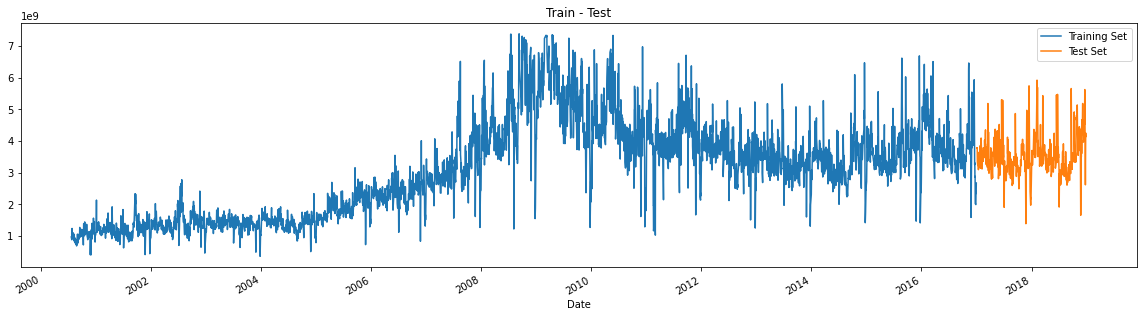

In [14]:
train = df.loc[df.index < '01-01-2017'].copy()
test = df.loc[df.index >= '01-01-2017'].copy()

fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, y='Volume',label='Training Set',title='Train - Test')
test.plot(ax=ax, y='Volume', label='Test Set')
plt.savefig('Graphs/Train-Test Split.pdf')

# DATA ANALYSIS
1) Occuring patterns: Are there any similarities in weekly/monthly/yearly basis?

## OCCURING PATTERNS?
* Check if there are some ireularities during days/weeks/months with higher trading volume
* No, there are not, throughout the weeks, months, years the volume is not showing any significant difference

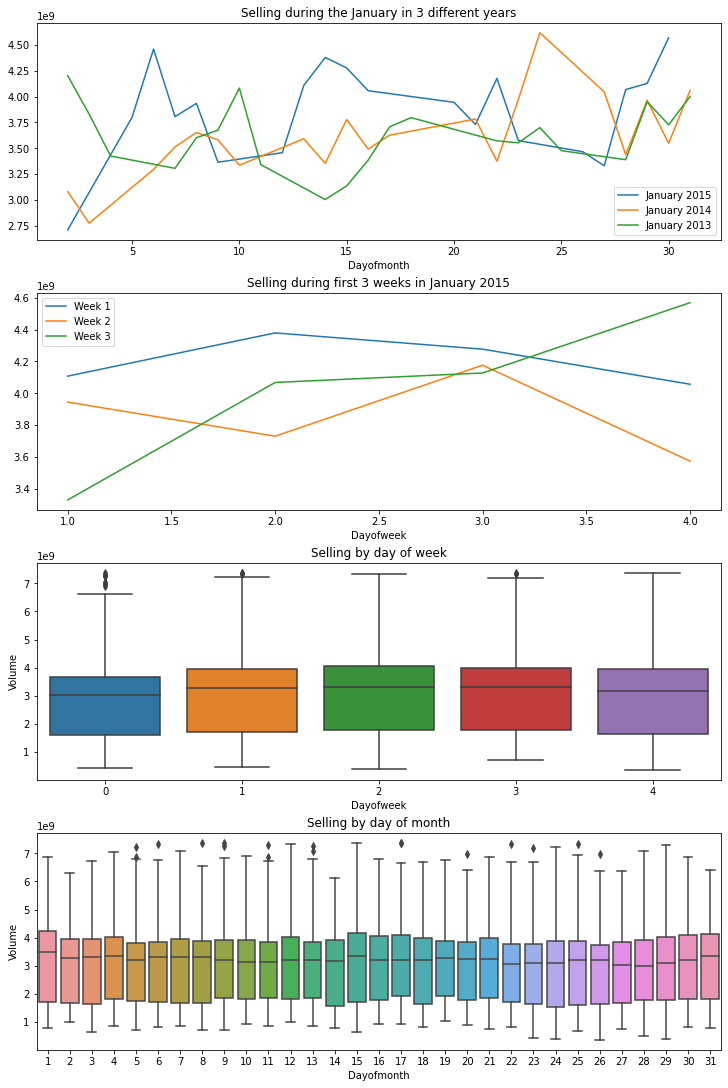

In [15]:
fig, axs = plt.subplots(4,1,figsize=(10, 15),constrained_layout = True)
df.loc[(df.index > '01-01-2015') & (df.index < '02-01-2015')].plot(ax=axs[0],x='Dayofmonth',y='Volume', label='January 2015')
df.loc[(df.index > '01-01-2014') & (df.index < '02-01-2014')].plot(ax=axs[0],x='Dayofmonth',y='Volume', label='January 2014')
df.loc[(df.index > '01-01-2013') & (df.index < '02-01-2013')].plot(ax=axs[0],x='Dayofmonth',y='Volume', label='January 2013')
axs[0].set_title('Selling during the January in 3 different years')

df.loc[(df.index > '01-12-2015') & (df.index < '01-19-2015')].plot(ax=axs[1],x='Dayofweek',y='Volume', label='Week 1')
df.loc[(df.index > '01-19-2015') & (df.index < '01-26-2015')].plot(ax=axs[1],x='Dayofweek',y='Volume', label='Week 2')
df.loc[(df.index > '01-26-2015') & (df.index < '02-02-2015')].plot(ax=axs[1],x='Dayofweek',y='Volume', label='Week 3')
axs[1].set_title('Selling during first 3 weeks in January 2015')

sns.boxplot(data=df, ax=axs[2],x='Dayofweek', y='Volume')
axs[2].set_title('Selling by day of week')

sns.boxplot(data=df, ax=axs[3],x='Dayofmonth', y='Volume')
axs[3].set_title('Selling by day of month')

plt.savefig('Graphs/Occuring Patters.pdf')

## DISTRIBUTION
* Check if the data are evely distributed
* TODO: Standardization / Normalization if not

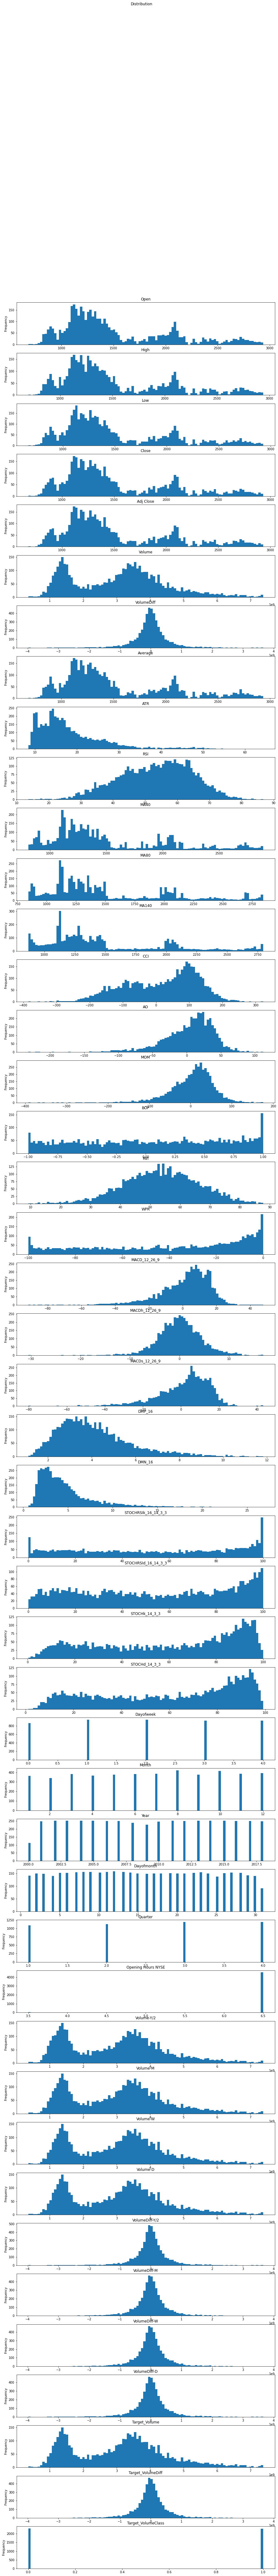

In [16]:
if FastRun is not True:
    cols = df.columns.tolist()
    fig, axs = plt.subplots(len(cols), 1,figsize=(15, len(cols)*3)) #TODO: zobrazit vsechno rozdeleni se spolecnou x osou, at zjistime, zda neco neni skew
    plt.suptitle('Distribution')
    for i in range(len(cols)):
        df[cols[i]].plot(kind='hist',bins=100,ax=axs[i],title=cols[i])
    plt.savefig('Graphs/Distribution.pdf')

## CORRELATION
* Correlation between all the features
* TODO: Investigate if the correlation is reasonable, if not, why?
* FastRun argument: Takes around 40s to generate, generate only if necessary

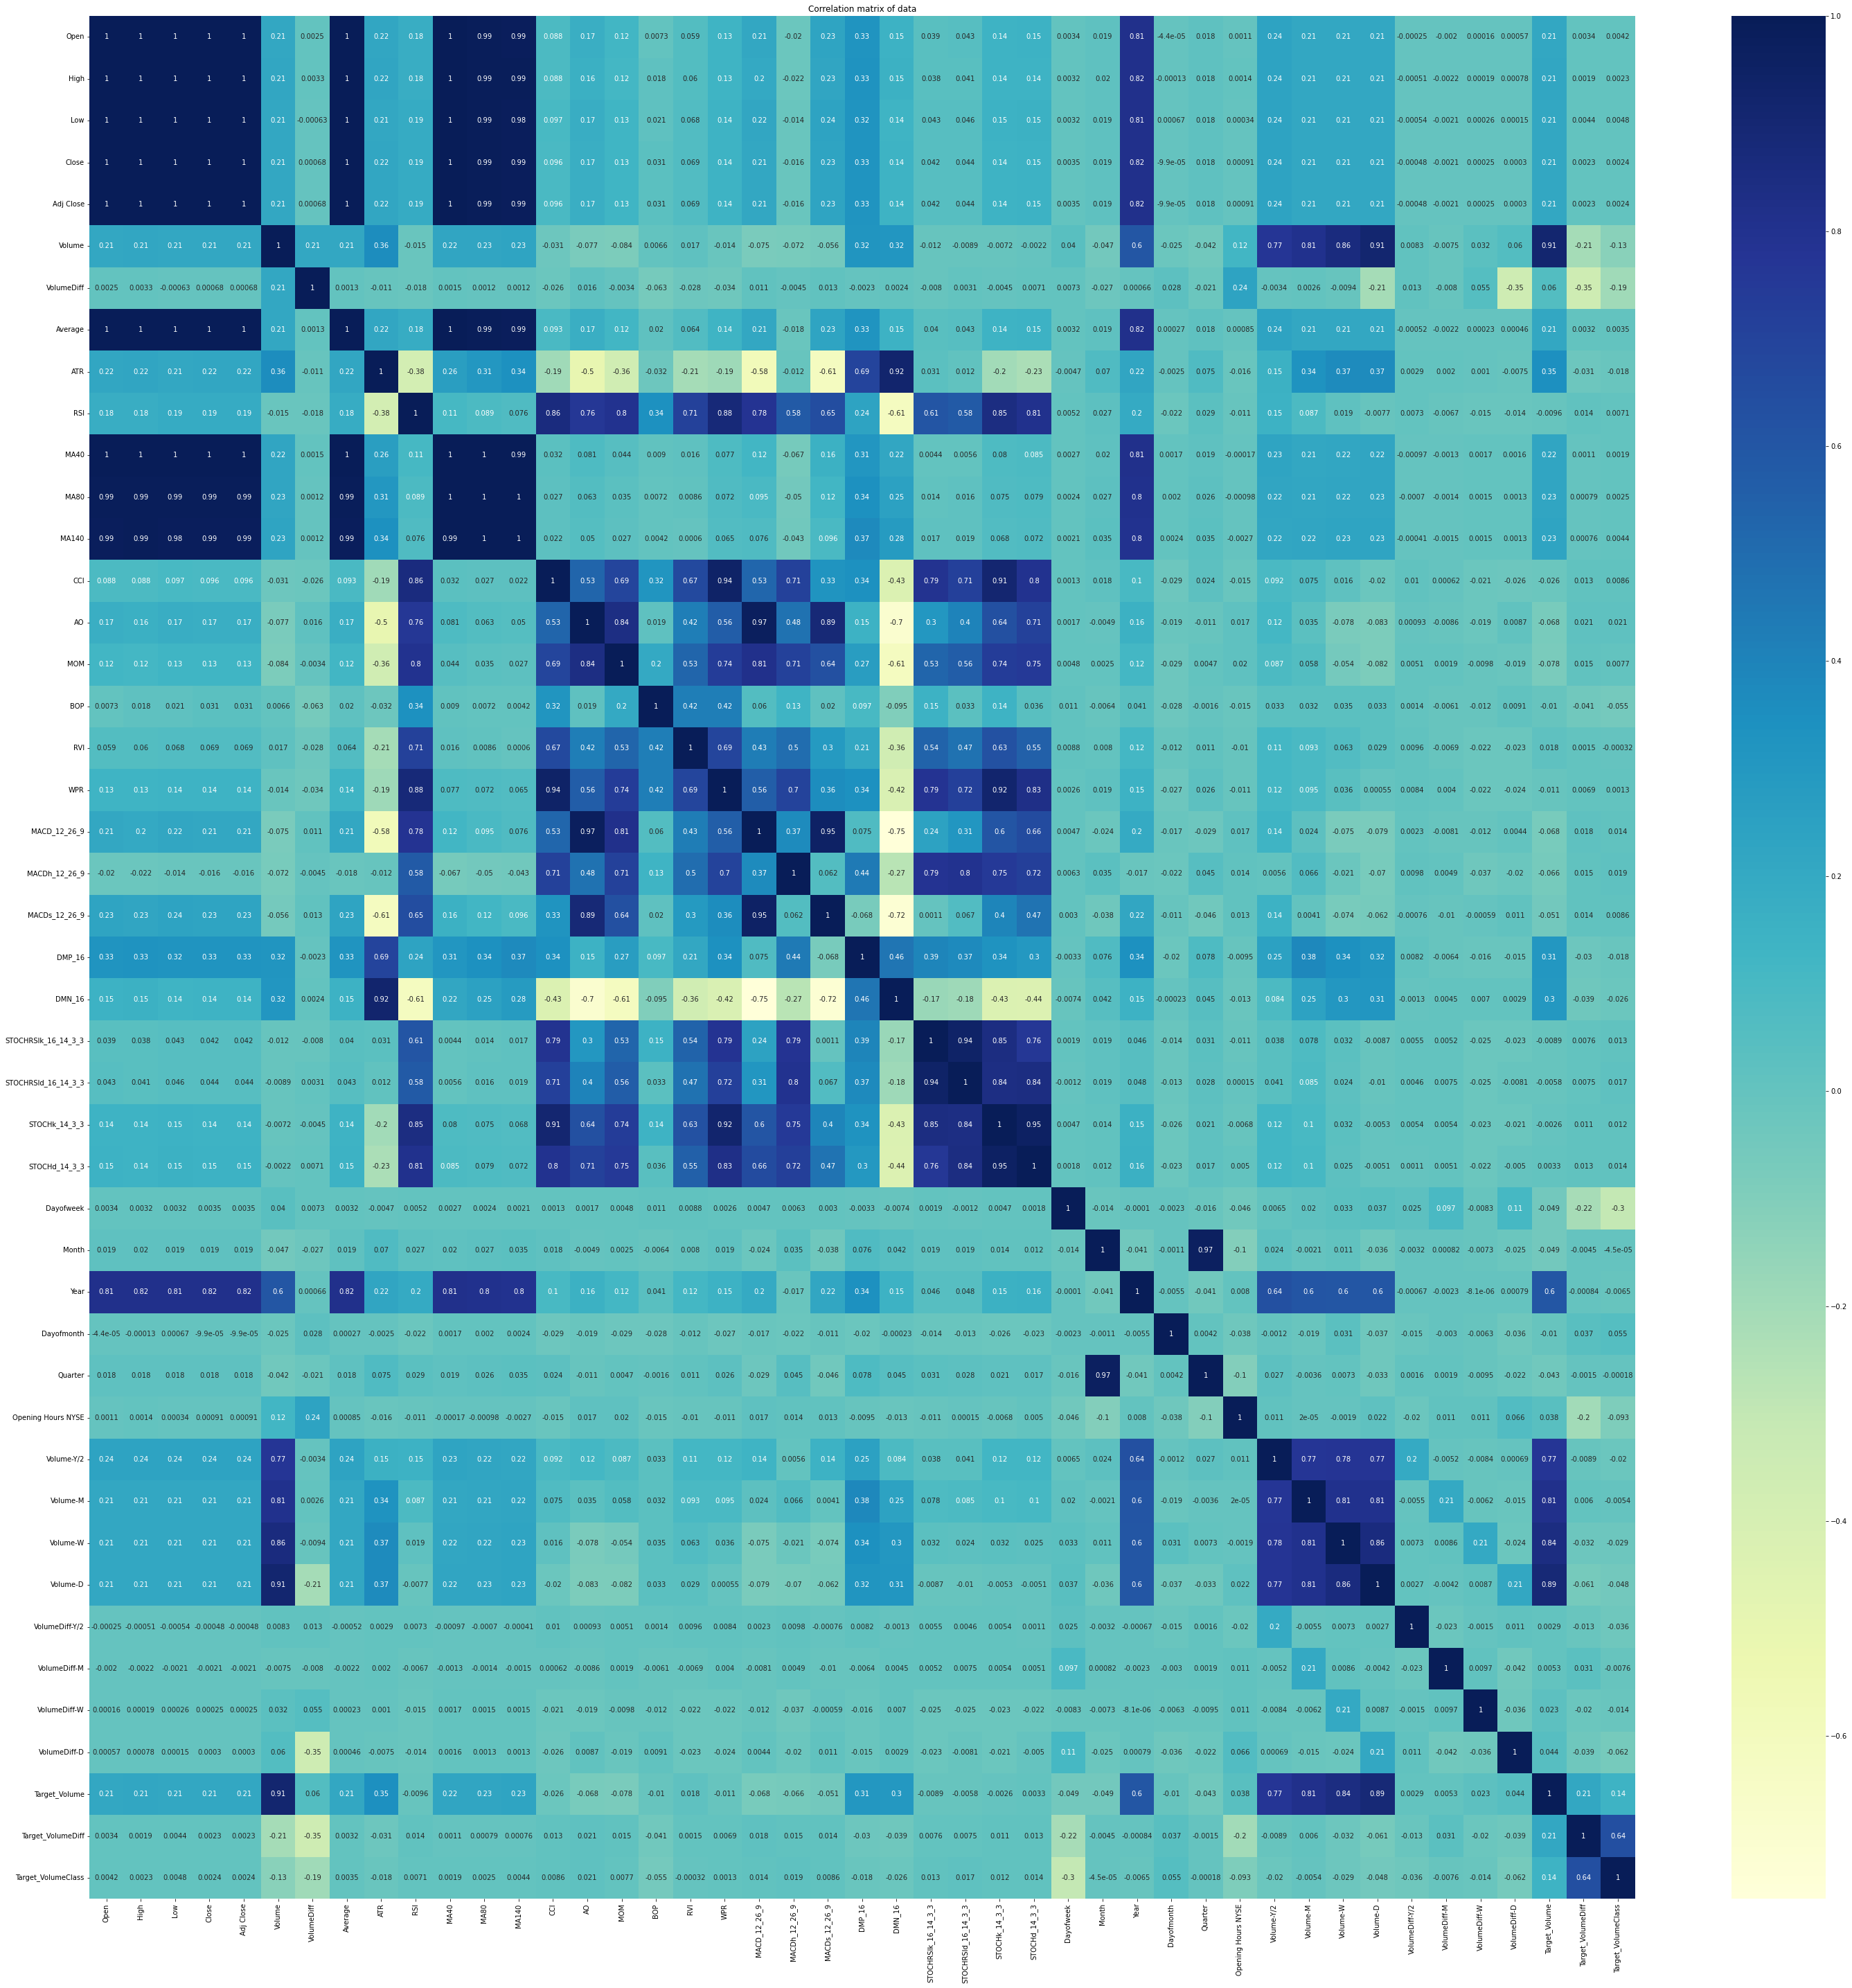

In [17]:
if FastRun is not True:
    plt.figure(figsize=(50, 50))
    plt.title('Correlation matrix of data')
    cor = df.corr()
    hm1 = sns.heatmap(cor, annot=True, cmap='YlGnBu')
    plt.savefig('Graphs/Correlation.pdf')

# XGBOOST
* Kaggle competitions proved that this algprithm is very powerful
* Although my main focus is on transformers, XGBoost could give a great baseline
* Three different models are trained based on the target
    1) Next day volume
    2) Next day volume difference
    3) Next day volume class

## MODEL 1 - VOLUME

### SETTING TARGET
* For each model we use different target
* Target_Volume, Target_VolumeDiff or Target_VolumeClass
* IMPORTANT: Do not use any target values in features

In [18]:
print(df.columns.tolist())
FEATURES = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D']
TARGET = 'Target_Volume'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D', 'Target_Volume', 'Target_VolumeDiff', 'Target_VolumeClass']


### HYPERPARAMETERS 
* Using hyperopt 
* Works similar to Optuna, which has better documentation
* TODO: Implement it with Optuna

In [19]:
def objective(space):
    """
    fmin() minimizes this function 
    return: evaluation metric which we minimize
    """
    reg=xgb.XGBRegressor(
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    colsample_bytree=space['colsample_bytree'],
                    min_child_weight = space['min_child_weight'],
                    learning_rate=space['learning_rate'],
                    early_stopping_rounds=space['early_stopping_rounds'])   
    reg.fit(X_train, y_train,
            eval_set=[(X_train,y_train),(X_test,y_test)],
            verbose=False)
    pred = reg.predict(X_test)
    accuracy = mean_absolute_error(test['Target_Volume'],pred)
    return {'loss': accuracy, 'status': STATUS_OK }

In [20]:
space={
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate'    : hp.uniform('learning_rate', 0.0005, 0.3),
        'early_stopping_rounds': hp.uniform ('early_stopping_rounds', 10,600)}
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

print("The best hyperparameters : ")
print(best_hyperparams)

100%|███████████████████████████████████████████████| 100/100 [03:06<00:00,  1.87s/trial, best loss: 297394606.4609218]
The best hyperparameters : 
{'colsample_bytree': 0.7907637477528255, 'early_stopping_rounds': 335.71869815093225, 'gamma': 5.556353827777829, 'learning_rate': 0.12313902848907296, 'min_child_weight': 10.0, 'reg_alpha': 170.0, 'reg_lambda': 0.8443170531463176}


In [21]:
hp.choice('max_depth', np.arange(3, 18, dtype=int))

### TRAINING
* Features: The attributes model is using as in input
* Target variables are the ones we predict
* Crucial to remove all Target values, as it already includes future data

In [22]:
reg = xgb.XGBRegressor(**best_hyperparams)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:2953800234.75507	validation_1-rmse:3132158095.92261
[10]	validation_0-rmse:909194173.59333	validation_1-rmse:930873355.75250
[20]	validation_0-rmse:444899227.73610	validation_1-rmse:486830256.62801
[30]	validation_0-rmse:354582381.12807	validation_1-rmse:461040079.80039
[40]	validation_0-rmse:327417666.57732	validation_1-rmse:466872773.05698
[50]	validation_0-rmse:305450555.13753	validation_1-rmse:469734318.53865
[60]	validation_0-rmse:294406442.52228	validation_1-rmse:469092707.77962
[70]	validation_0-rmse:284199928.06913	validation_1-rmse:468260591.98990
[80]	validation_0-rmse:271730945.75326	validation_1-rmse:466371557.49597
[90]	validation_0-rmse:257117938.86397	validation_1-rmse:467318898.29307
[99]	validation_0-rmse:245422172.71762	validation_1-rmse:467652622.83524


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7907637477528255,
             early_stopping_rounds=335.71869815093225, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=5.556353827777829,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.12313902848907296,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=10.0,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

### TESTING
* Using the trained model on test data
* Add column 'Prediction' to the dataset

In [23]:
test['Prediction_'+TARGET] = reg.predict(X_test)
test['Model1'] = test['Prediction_'+TARGET]
#df = df.merge(test[['Prediction_'+TARGET]], how='left', left_index=True, right_index=True)
#df = df.merge(test[['Model1']], how='left', left_index=True, right_index=True)

### FEATURE IMPORTANCE
* Year and Volume the most important
* Volume reasonable, since the model predicts same value as the day before
* TODO: Why year? It does not make any sense to me...

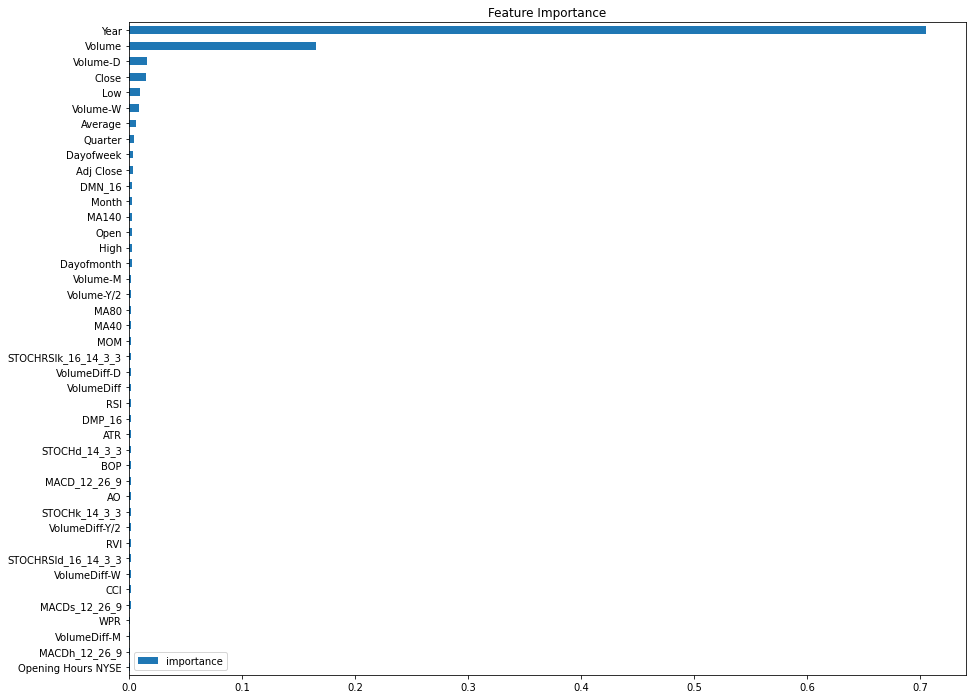

In [24]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')
plt.savefig('Graphs/XGB '+ TARGET + ' Feature Importance.pdf')

### ANALYZE THE RESULTS
* It looks great on the yearly graph, hurraayy!
* When zoomed in, the model predicts the price from the previous day
* But it does not predict the previous price only, the RMSE score is better than baseline using the previous day values

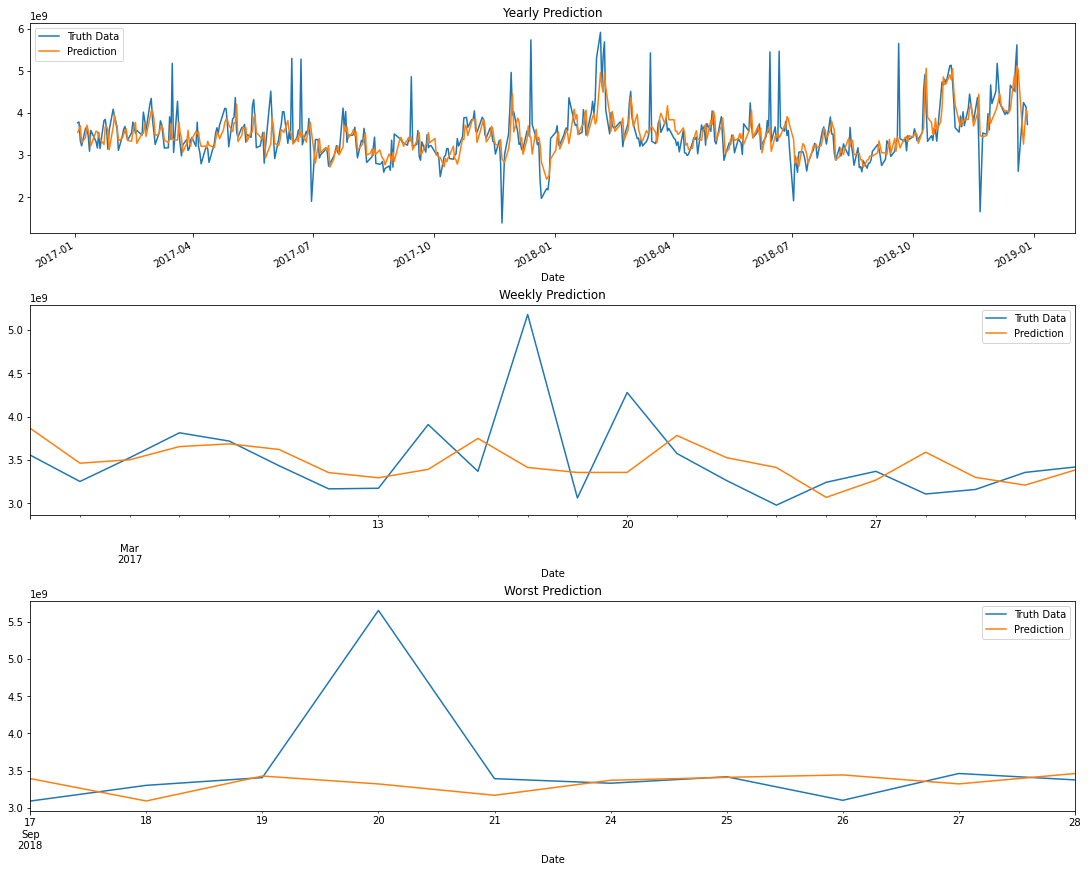

In [25]:
fig, axs = plt.subplots(3,1,figsize=(15, 12),constrained_layout = True)

test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y=TARGET,label='Truth Data')
test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y='Prediction_'+TARGET,label='Prediction')
axs[0].set_title('Yearly Prediction')

test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y=TARGET,label='Truth Data')
test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y='Prediction_'+TARGET,label ='Prediction')
axs[1].set_title('Weekly Prediction')

test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y=TARGET,label='Truth Data')
test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y='Prediction_'+TARGET,label ='Prediction')
axs[2].set_title('Worst Prediction')

plt.savefig('Graphs/XGB Prediction_'+TARGET+'.pdf')

In [26]:
# WORST PREDICTIONS
test['Error_'+TARGET] = np.abs(test[TARGET] - test['Prediction_'+TARGET]) #TODO: HERE SOMETHIGN IS WRONG
test.groupby(test.index)['Error_'+TARGET].mean().sort_values(ascending=False).head(10)

Date
2018-12-20    2.411313e+09
2018-09-20    2.331192e+09
2017-12-14    2.313511e+09
2018-06-21    2.059977e+09
2017-06-15    1.876013e+09
2018-06-14    1.859656e+09
2017-06-22    1.858127e+09
2018-11-21    1.811909e+09
2018-03-15    1.787865e+09
2017-03-16    1.766347e+09
Name: Error_Target_Volume, dtype: float64

## MODEL 2 - VOLUME DIFF

### SETTING TARGET
* For each model we use different target
* Target_Volume, Target_VolumeDiff or Target_VolumeClass

In [27]:
print(df.columns.tolist())
FEATURES = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D']
TARGET = 'Target_VolumeDiff'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D', 'Target_Volume', 'Target_VolumeDiff', 'Target_VolumeClass']


### HYPERPARAMETERS 
* Using hyperopt 
* Works similar to Optuna, which has better documentation
* TODO: Implement it with Optuna

In [28]:
def objective(space):
    """
    fmin() minimizes this function 
    return: evaluation metric which we minimize
    """
    reg=xgb.XGBRegressor(
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    colsample_bytree=space['colsample_bytree'],
                    min_child_weight = space['min_child_weight'],
                    learning_rate=space['learning_rate'],
                    early_stopping_rounds=space['early_stopping_rounds'])   
    reg.fit(X_train, y_train,
            eval_set=[(X_train,y_train),(X_test,y_test)],
            verbose=False)
    pred = reg.predict(X_test)+test['Volume']
    accuracy = mean_absolute_error(test['Target_Volume'],pred)
    return {'loss': accuracy, 'status': STATUS_OK }

In [29]:
space={
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate'    : hp.uniform('learning_rate', 0.0005, 0.3),
        'early_stopping_rounds': hp.uniform ('early_stopping_rounds', 10,600)}
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

print("The best hyperparameters : ")
print(best_hyperparams)

100%|███████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/trial, best loss: 289656753.3692385]
The best hyperparameters : 
{'colsample_bytree': 0.6424548437704135, 'early_stopping_rounds': 546.2347131091592, 'gamma': 3.540910502468371, 'learning_rate': 0.16241430712202873, 'min_child_weight': 7.0, 'reg_alpha': 105.0, 'reg_lambda': 0.726778119488219}


### TRAINING
* Features: The attributes model is using as in input
* Target variables are the ones we predict
* Crucial to remove all Target values, as it already includes future data

In [30]:
reg = xgb.XGBRegressor(**best_hyperparams)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:547836329.13779	validation_1-rmse:547715244.81953
[10]	validation_0-rmse:409219282.66338	validation_1-rmse:461502849.32667
[20]	validation_0-rmse:350964301.48800	validation_1-rmse:443902002.84232
[30]	validation_0-rmse:315045731.43357	validation_1-rmse:441525253.76073
[40]	validation_0-rmse:296416143.70131	validation_1-rmse:445534479.67331
[50]	validation_0-rmse:275795539.25981	validation_1-rmse:454505480.21592
[60]	validation_0-rmse:250874990.97287	validation_1-rmse:457803131.84654
[70]	validation_0-rmse:238030305.92216	validation_1-rmse:455860855.09233
[80]	validation_0-rmse:221339947.43473	validation_1-rmse:453694312.63801
[90]	validation_0-rmse:208574258.97519	validation_1-rmse:453464457.09968
[99]	validation_0-rmse:198942693.10537	validation_1-rmse:452627554.02978


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6424548437704135,
             early_stopping_rounds=546.2347131091592, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.540910502468371,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.16241430712202873,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=7.0,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

### TESTING
* Using the trained model on test data
* Add column 'Prediction' to the dataset

In [31]:
test['Prediction_'+TARGET] = reg.predict(X_test)
test['Model2'] = test['Prediction_'+TARGET]+test['Volume']

### FEATURE IMPORTANCE
* Year and Volume the most important
* Volume reasonable, since the model predicts same value as the day before
* TODO: Why year? It does not make any sense to me...

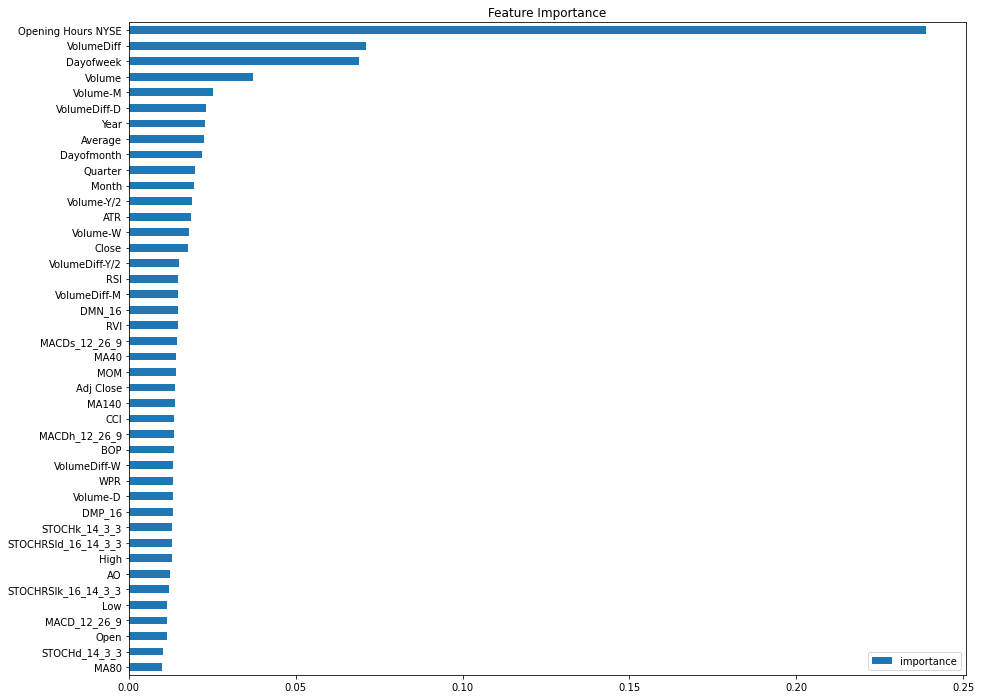

In [32]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')
plt.savefig('Graphs/XGB '+ TARGET + ' Feature Importance.pdf')

### ANALYZE THE RESULTS
* It looks great on the yearly graph, hurraayy!
* When zoomed in, the model predicts the price from the previous day
* But it does not predict the previous price only, the RMSE score is better than baseline using the previous day values

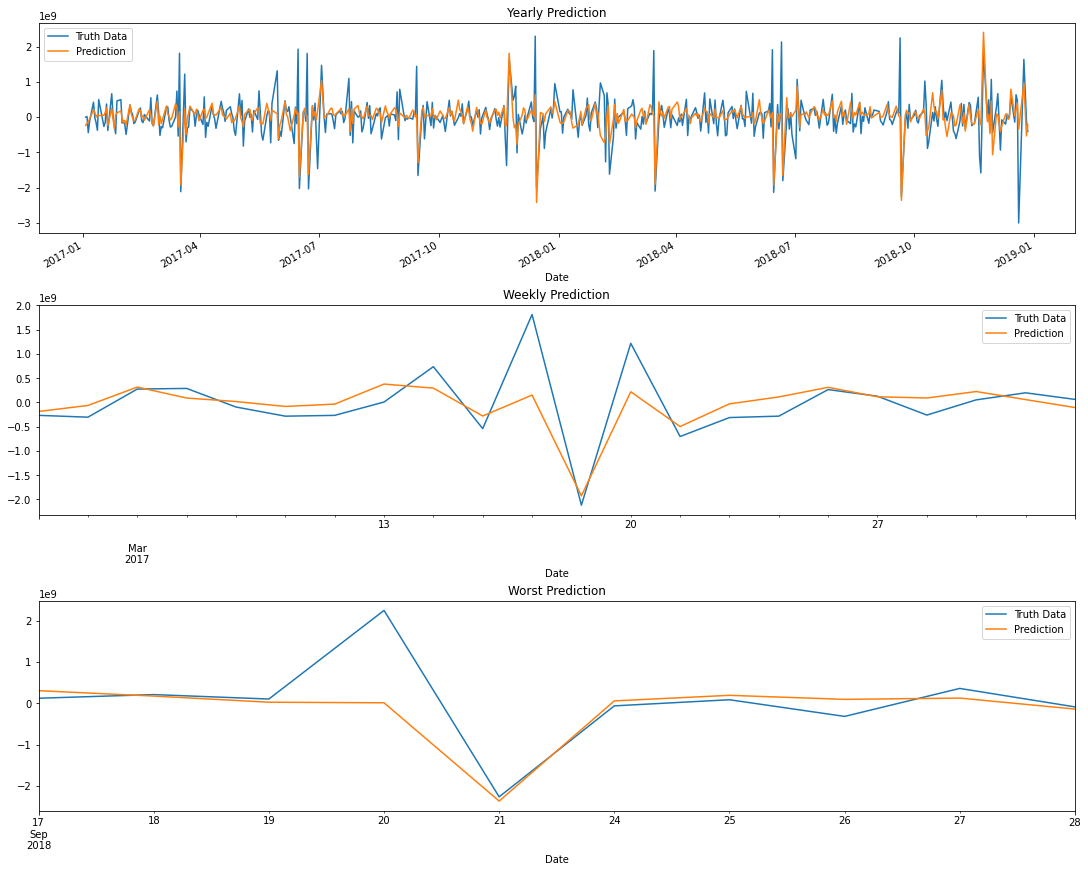

In [33]:
fig, axs = plt.subplots(3,1,figsize=(15, 12),constrained_layout = True)

test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y=TARGET,label='Truth Data')
test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y='Prediction_'+TARGET,label='Prediction')
axs[0].set_title('Yearly Prediction')

test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y=TARGET,label='Truth Data')
test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y='Prediction_'+TARGET,label ='Prediction')
axs[1].set_title('Weekly Prediction')

test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y=TARGET,label='Truth Data')
test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y='Prediction_'+TARGET,label ='Prediction')
axs[2].set_title('Worst Prediction')

plt.savefig('Graphs/XGB Prediction_'+TARGET+'.pdf')

In [34]:
# WORST PREDICTIONS
test['Error_'+TARGET] = np.abs(test[TARGET] - test['Prediction_'+TARGET]) #TODO: HERE SOMETHIGN IS WRONG
test.groupby(test.index)['Error_'+TARGET].mean().sort_values(ascending=False).head(10)

Date
2018-12-20    2.664954e+09
2018-09-20    2.233025e+09
2018-06-21    2.036960e+09
2018-03-15    1.848430e+09
2017-06-15    1.815502e+09
2018-06-14    1.790662e+09
2017-06-22    1.778707e+09
2017-03-16    1.660069e+09
2017-12-14    1.658711e+09
2017-06-30    1.639470e+09
Name: Error_Target_VolumeDiff, dtype: float64

### HYPERPARAMETERS 
* Using hyperopt 
* Works similar to Optuna, which has better documentation
* TODO: Implement it with Optuna

## MODEL 3 - VOLUME CLASS

### SETTING TARGET
* For each model we use different target
* Target_Volume, Target_VolumeDiff or Target_VolumeClass

In [35]:
print(df.columns.tolist())
FEATURES = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D']
TARGET = 'Target_VolumeClass'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D', 'Target_Volume', 'Target_VolumeDiff', 'Target_VolumeClass']


### HYPERPARAMETERS 
* Using hyperopt 
* Using Classifier instead of Regressor
* TODO: Implement it with Optuna

In [36]:
def objective(space):
    """
    fmin() minimizes this function 
    return: evaluation metric which we minimize
    """
    reg=xgb.XGBClassifier(
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    colsample_bytree=space['colsample_bytree'],
                    min_child_weight = space['min_child_weight'],
                    learning_rate=space['learning_rate'],
                    early_stopping_rounds=space['early_stopping_rounds'])   
    reg.fit(X_train, y_train,
            eval_set=[(X_train,y_train),(X_test,y_test)],
            verbose=False)   
    pred = reg.predict(X_test)
    accuracy = accuracy_score(test[TARGET],pred)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [37]:
space={
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate'    : hp.uniform('learning_rate', 0.0005, 0.3),
        'early_stopping_rounds': hp.uniform ('early_stopping_rounds', 10,600)}
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

print("The best hyperparameters : ")
print(best_hyperparams)

100%|█████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/trial, best loss: -0.6693386773547094]
The best hyperparameters : 
{'colsample_bytree': 0.7621870746148985, 'early_stopping_rounds': 311.3349877418642, 'gamma': 4.409288905782, 'learning_rate': 0.15847306273336537, 'min_child_weight': 5.0, 'reg_alpha': 45.0, 'reg_lambda': 0.965621935181273}


### TRAINING
* Features: The attributes model is using as in input
* Target variables are the ones we predict
* Crucial to remove all Target values, as it already includes future data
* IMPORTANT: Classifier need to be used instead of Regressor to predict categories
* Categories must be 0 and 1

In [38]:
reg = xgb.XGBClassifier(**best_hyperparams)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-logloss:0.67492	validation_1-logloss:0.67685
[10]	validation_0-logloss:0.62055	validation_1-logloss:0.62808
[20]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[30]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[40]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[50]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[60]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[70]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[80]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[90]	validation_0-logloss:0.60259	validation_1-logloss:0.61342
[99]	validation_0-logloss:0.60259	validation_1-logloss:0.61342


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7621870746148985,
              early_stopping_rounds=311.3349877418642, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.409288905782,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.15847306273336537,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5.0,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

### TESTING
* Using the trained model on test data
* Add column 'Prediction' to the dataset
* To be able to compare with other models, we add average volume difference in directions we get from results

In [39]:
avg_volume_diff = (abs(test['VolumeDiff'])).mean()
test['Prediction_'+TARGET] = reg.predict(X_test)
test['Model3'] = test['Volume'] + (2*test['Prediction_'+TARGET]-1)*avg_volume_diff #[1,0] - [-1,1]

### FEATURE IMPORTANCE
* Year and Volume the most important
* Volume reasonable, since the model predicts same value as the day before
* TODO: Why year? It does not make any sense to me...

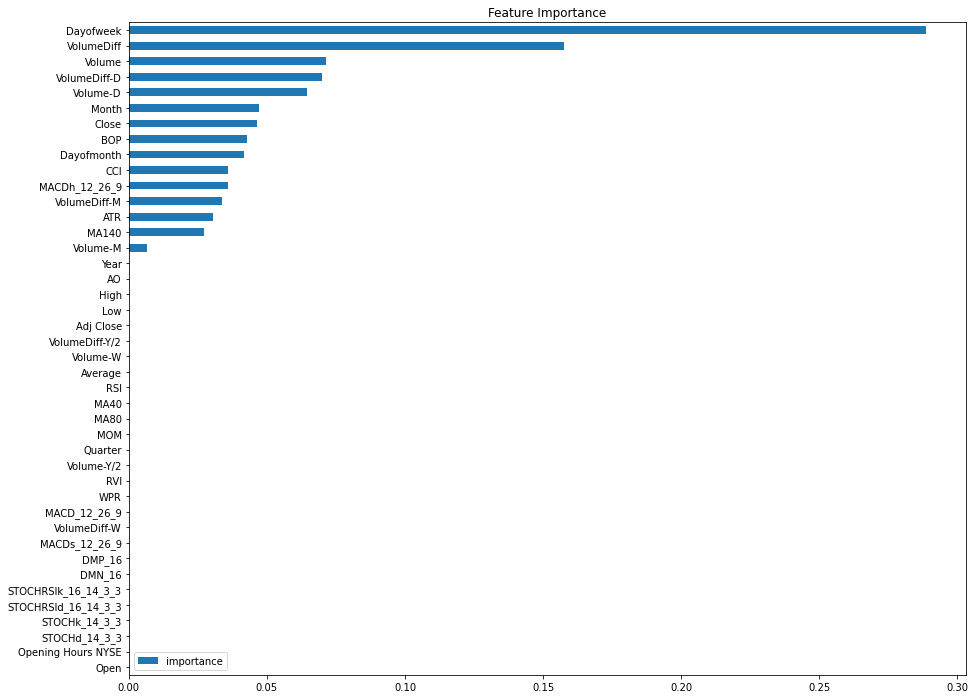

In [40]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')
plt.savefig('Graphs/XGB '+ TARGET + ' Feature Importance.pdf')

### ANALYZE THE RESULTS
* It looks great on the yearly graph, hurraayy!
* When zoomed in, the model predicts the price from the previous day
* But it does not predict the previous price only, the RMSE score is better than baseline using the previous day values

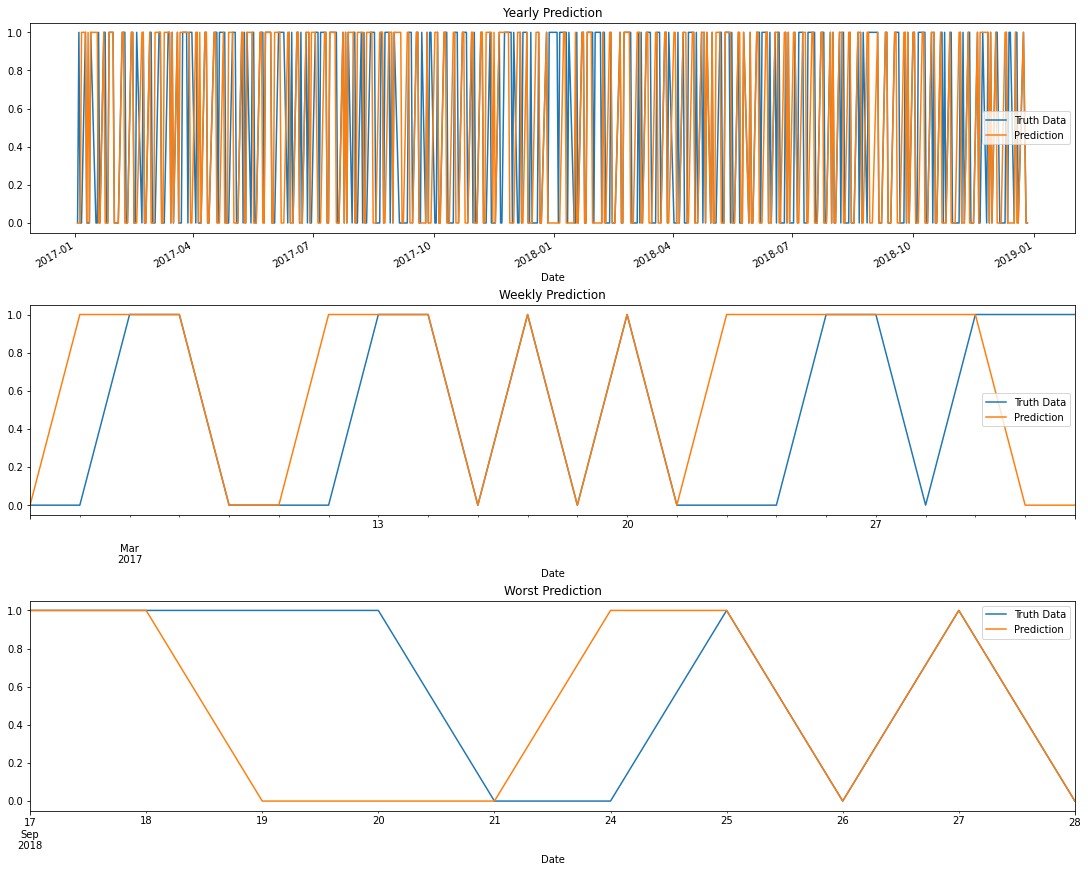

In [41]:
fig, axs = plt.subplots(3,1,figsize=(15, 12),constrained_layout = True)

test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y=TARGET,label='Truth Data')
test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y='Prediction_'+TARGET,label='Prediction')
axs[0].set_title('Yearly Prediction')

test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y=TARGET,label='Truth Data')
test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y='Prediction_'+TARGET,label ='Prediction')
axs[1].set_title('Weekly Prediction')

test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y=TARGET,label='Truth Data')
test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y='Prediction_'+TARGET,label ='Prediction')
axs[2].set_title('Worst Prediction')

plt.savefig('Graphs/XGB Prediction_'+TARGET+'.pdf')

In [42]:
print("Model3 Class Prediction Accuracy:",accuracy_score(test[TARGET],test['Prediction_'+TARGET]))

Model3 Class Prediction Accuracy: 0.6693386773547094


## MODEL 4 - BEST OF THE BEST?
* Same as model 2, but with only 5 most important features

### SETTING TARGET
* For each model we use different target
* Target_Volume, Target_VolumeDiff or Target_VolumeClass

In [43]:
print(df.columns.tolist())
FEATURES = ['Volume', 'VolumeDiff', 'Average', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Opening Hours NYSE']
TARGET = 'Target_VolumeDiff'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Quarter', 'Opening Hours NYSE', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D', 'Target_Volume', 'Target_VolumeDiff', 'Target_VolumeClass']


### HYPERPARAMETERS 
* Using hyperopt 
* Works similar to Optuna, which has better documentation
* TODO: Implement it with Optuna

In [44]:
def objective(space):
    """
    fmin() minimizes this function 
    return: evaluation metric which we minimize
    """
    reg=xgb.XGBRegressor(
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    colsample_bytree=space['colsample_bytree'],
                    min_child_weight = space['min_child_weight'],
                    learning_rate=space['learning_rate'],
                    early_stopping_rounds=space['early_stopping_rounds'])   
    reg.fit(X_train, y_train,
            eval_set=[(X_train,y_train),(X_test,y_test)],
            verbose=False)
    pred = reg.predict(X_test)+test['Volume']
    accuracy = mean_absolute_error(test['Target_Volume'],pred)
    return {'loss': accuracy, 'status': STATUS_OK }

In [45]:
space={
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate'    : hp.uniform('learning_rate', 0.0005, 0.3),
        'early_stopping_rounds': hp.uniform ('early_stopping_rounds', 10,600)}
trials = Trials()
best_hyperparams = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=100,trials=trials)

print("The best hyperparameters : ")
print(best_hyperparams)

100%|██████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63trial/s, best loss: 284199543.28807616]
The best hyperparameters : 
{'colsample_bytree': 0.8843430831665554, 'early_stopping_rounds': 43.374786679114905, 'gamma': 3.760455587529585, 'learning_rate': 0.21921371745483892, 'min_child_weight': 10.0, 'reg_alpha': 53.0, 'reg_lambda': 0.1320020660043066}


### TRAINING
* Features: The attributes model is using as in input
* Target variables are the ones we predict
* Crucial to remove all Target values, as it already includes future data

In [46]:
reg = xgb.XGBRegressor(**best_hyperparams)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:544535805.14055	validation_1-rmse:537091724.82684
[10]	validation_0-rmse:419504648.39351	validation_1-rmse:445450614.74419
[20]	validation_0-rmse:371842419.03168	validation_1-rmse:437334649.23256
[30]	validation_0-rmse:358156133.68777	validation_1-rmse:448919680.43096
[40]	validation_0-rmse:342948458.48159	validation_1-rmse:453329586.36644
[50]	validation_0-rmse:330358928.61875	validation_1-rmse:454064659.57100
[60]	validation_0-rmse:315271099.63114	validation_1-rmse:455530100.39942


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8843430831665554,
             early_stopping_rounds=43.374786679114905, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.760455587529585,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.21921371745483892,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=10.0,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

### TESTING
* Using the trained model on test data
* Add column 'Prediction' to the dataset

In [47]:
test['Prediction_'+TARGET+'2'] = reg.predict(X_test)
test['Model4'] = test['Prediction_'+TARGET+'2']+test['Volume']

### FEATURE IMPORTANCE
* Year and Volume the most important
* Volume reasonable, since the model predicts same value as the day before
* TODO: Why year? It does not make any sense to me...

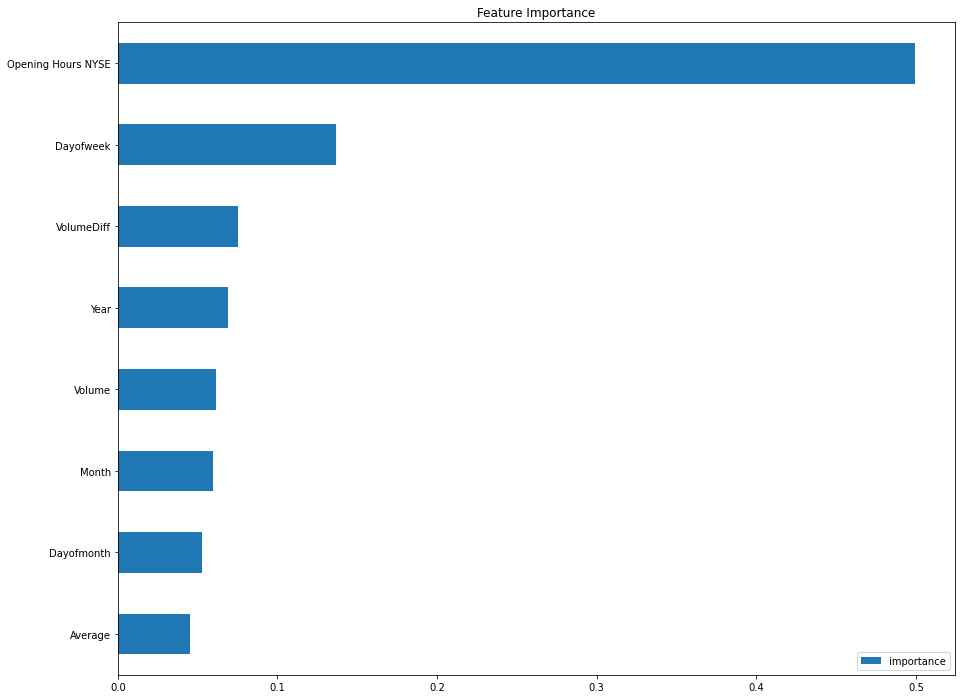

In [48]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')
plt.savefig('Graphs/XGB '+ TARGET +'2' + ' Feature Importance.pdf')

### ANALYZE THE RESULTS
* It looks great on the yearly graph, hurraayy!
* When zoomed in, the model predicts the price from the previous day
* But it does not predict the previous price only, the RMSE score is better than baseline using the previous day values

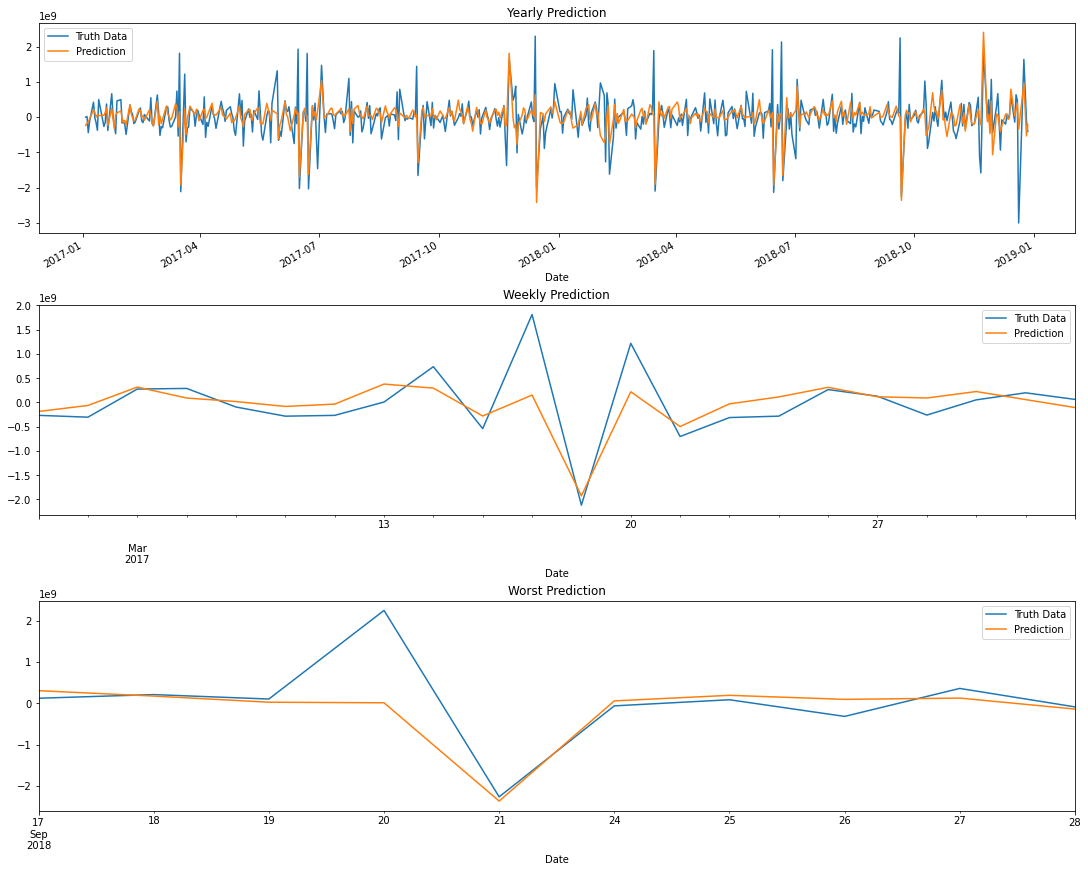

In [49]:
fig, axs = plt.subplots(3,1,figsize=(15, 12),constrained_layout = True)

test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y=TARGET,label='Truth Data')
test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=axs[0],y='Prediction_'+TARGET,label='Prediction')
axs[0].set_title('Yearly Prediction')

test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y=TARGET,label='Truth Data')
test.loc[(test.index > '03-01-2017') & (test.index < '04-01-2017')].plot(ax=axs[1],y='Prediction_'+TARGET,label ='Prediction')
axs[1].set_title('Weekly Prediction')

test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y=TARGET,label='Truth Data')
test.loc[(test.index > '09-15-2018') & (test.index < '09-30-2018')].plot(ax=axs[2],y='Prediction_'+TARGET,label ='Prediction')
axs[2].set_title('Worst Prediction')

plt.savefig('Graphs/XGB Prediction_'+TARGET+'2'+'.pdf')

In [50]:
# WORST PREDICTIONS
test['Error_'+TARGET+'2'] = np.abs(test[TARGET] - test['Prediction_'+TARGET+'2']) #TODO: HERE SOMETHIGN IS WRONG
test.groupby(test.index)['Error_'+TARGET+'2'].mean().sort_values(ascending=False).head(10)

Date
2018-12-20    2.408790e+09
2018-09-20    2.190474e+09
2018-06-21    2.142508e+09
2017-12-14    2.062286e+09
2018-03-15    1.968433e+09
2017-06-22    1.824574e+09
2017-06-30    1.818190e+09
2018-06-14    1.768021e+09
2017-06-15    1.763201e+09
2017-03-16    1.624416e+09
Name: Error_Target_VolumeDiff2, dtype: float64

### PREDICTIONS
* Save the predictions with a wider x scale

In [51]:
test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=ax,y=TARGET,label='Truth Data',figsize=(50,15))
test.loc[(test.index > '01-01-2017') & (test.index < '12-31-2018')].plot(ax=ax,y='Prediction_'+TARGET+'2',label='Prediction')
plt.savefig('Graphs/Final Predictions.pdf')

<Figure size 432x288 with 0 Axes>

### SAVE MODEL
* Model4 gives the best results so far, let's save it!
* Save the model for future use without training

In [52]:
reg.save_model('XGB_Model.json')

## COMPARE RESULTS
* Discussion about the results, are they as expected?

1) Model 1 - Volume
    * The model is working better than expected
    * Why? When you are predicting stock price, the economy is growing, or falling, therefore these models end up predicting price from a previous day
    * Here it is not the case, as the volume is oscilating about the similar level for the entire time
    
2) Model 2 - Volume Diff
    * The model is working worse than expected
    * Expectations were to beat the Volume model by a lot
    * Since the volume is not changing as much as expected, the results are not that satisfying

3) Model 3 - Volume Class
    * Unconventional solution
    * Trying to predict only if the price goes up and down
    * Based on category, multiply it by average volume difference

In [53]:
test.tail()

,Open,High,Low,Close,Adj Close,Volume,VolumeDiff,Average,ATR,RSI,MA40,MA80,MA140,CCI,AO,MOM,BOP,RVI,WPR,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,DMP_16,DMN_16,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,STOCHk_14_3_3,STOCHd_14_3_3,Dayofweek,Month,Year,Dayofmonth,Quarter,Opening Hours NYSE,Volume-Y/2,Volume-M,Volume-W,Volume-D,VolumeDiff-Y/2,VolumeDiff-M,VolumeDiff-W,VolumeDiff-D,Target_Volume,Target_VolumeDiff,Target_VolumeClass,Prediction_Target_Volume,Model1,Error_Target_Volume,Prediction_Target_VolumeDiff,Model2,Error_Target_VolumeDiff,Prediction_Target_VolumeClass,Model3,Prediction_Target_VolumeDiff2,Model4,Error_Target_VolumeDiff2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-19,2547.050049,2585.290039,2488.959961,2506.959961,2506.959961,5152830000,6.336400e+08,2537.125000,53.860363,28.349112,2689.477747,2781.094870,2787.245933,-154.501064,-108.403786,-166.489990,-0.416174,35.414271,-94.216309,-47.884620,-16.099978,-31.784642,7.914572,20.893482,0.050241,4.162284,5.974308,9.134747,2,12,2018,19,4,6.5,3.332140e+09,3.996970e+09,4.029300e+09,4.519190e+09,-3.390200e+08,-2.079900e+08,65860000.0,-1.422300e+08,5.619780e+09,4.669500e+08,1,5.118430e+09,5.118430e+09,5.013503e+08,393816000.0,5.546646e+09,7.313400e+07,0,4.784039e+09,-545798720.0,4.607031e+09,1.012749e+09
2018-12-20,2496.770020,2509.629883,2441.179932,2467.419922,2467.419922,5619780000,4.669500e+08,2475.404907,54.772212,25.526865,2682.645996,2775.728369,2785.337360,-170.645866,-136.841151,-214.750000,-0.428782,28.631635,-92.690811,-55.826359,-19.233374,-36.592986,7.419911,22.573891,0.050241,0.501810,6.506943,6.365536,3,12,2018,20,4,6.5,3.336580e+09,3.806940e+09,3.978340e+09,5.152830e+09,4.440000e+06,-1.900300e+08,-50960000.0,6.336400e+08,2.613670e+09,-3.006110e+09,0,5.024983e+09,5.024983e+09,2.411313e+09,-341156128.0,5.278624e+09,2.664954e+09,0,5.250989e+09,-597320256.0,5.022460e+09,2.408790e+09
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,-3.006110e+09,2380.720093,58.618938,19.406212,2675.020996,2768.898120,2782.510432,-204.233034,-173.454621,-392.689941,-0.834908,22.617655,-100.000000,-70.691397,-27.278729,-43.412668,6.956167,26.793013,0.000000,0.033494,4.364293,5.615181,0,12,2018,24,4,3.5,5.468110e+09,4.370820e+09,4.064370e+09,5.619780e+09,2.131530e+09,5.638800e+08,86030000.0,4.669500e+08,4.249740e+09,1.636070e+09,1,3.258980e+09,3.258980e+09,9.907599e+08,958969408.0,3.572639e+09,6.771006e+08,1,2.982461e+09,553880832.0,3.167551e+09,1.082189e+09
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,1.636070e+09,2407.170044,62.529000,35.977668,2669.074243,2763.318869,2780.502574,-130.769822,-195.736870,-270.100098,0.863013,36.673090,-73.298079,-72.230780,-23.054490,-49.176290,10.110151,25.118449,14.185260,4.745167,11.625723,7.498986,2,12,2018,26,4,6.5,3.663280e+09,3.237400e+09,4.661420e+09,2.613670e+09,-1.804830e+09,-1.133420e+09,597050000.0,-3.006110e+09,4.139010e+09,-1.107300e+08,0,4.084650e+09,4.084650e+09,5.436027e+07,-534992320.0,3.714748e+09,4.242623e+08,0,3.880949e+09,-526447136.0,3.723293e+09,4.157171e+08
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,-1.107300e+08,2443.520020,64.318447,38.447644,2664.827747,2758.165121,2778.477431,-92.019120,-208.844480,-271.339844,0.508227,47.288765,-68.639761,-70.928113,-17.401459,-53.526655,10.812022,23.548546,30.484833,14.890031,22.289302,12.759773,3,12,2018,27,4,6.5,3.568900e+09,1.651680e+09,4.519190e+09,4.249740e+09,-9.438000e+07,-1.585720e+09,-142230000.0,1.636070e+09,3.728440e+09,-4.105700e+08,0,3.920767e+09,3.920767e+09,1.923267e+08,-219725504.0,3.919284e+09,1.908445e+08,0,3.770219e+09,-69257840.0,4.069752e+09,3.413122e+08


### ROOT MEAN SQUARED ERROR (RMSE)
* MSE Differ based on whether the values of the response variable are scaled or not
* RMSE takes care of the fact related to whether the values of the response variable are scaled or not
* Can vary from 0 to any larger number

In [54]:
score_baseline = np.sqrt(mean_squared_error(test['Volume'], test['Target_Volume']))
score_volume = np.sqrt(mean_squared_error(test['Target_Volume'], test['Model1']))
score_volumediff = np.sqrt(mean_squared_error(test['Target_Volume'], test['Model2']))
score_volumeclass = np.sqrt(mean_squared_error(test['Target_Volume'], test['Model3']))
score_volumediff2 = np.sqrt(mean_squared_error(test['Target_Volume'], test['Model4']))
print(f'Baseline RMSE Score    : {score_baseline:0.3f}')
print(f'Volume RMSE Score      : {score_volume:0.3f}')
print(f'VolumeDiff RMSE Score  : {score_volumediff:0.3f}')
print(f'VolumeClass RMSE Score : {score_volumeclass:0.3f}')
print(f'VolumeDiff2 RMSE Score : {score_volumediff2:0.3f}')

Baseline RMSE Score    : 575655527.700
Volume RMSE Score      : 457126473.314
VolumeDiff RMSE Score  : 438614859.002
VolumeClass RMSE Score : 593058044.896
VolumeDiff2 RMSE Score : 436921722.561


### SUM OF SQUARED ERRORS
* Used for calculating R2 (R2 = 1 – (SSE/SST))

In [55]:
score_baseline = np.sum((test['Volume'] - test['Target_Volume'])**2)
score_volume = np.sum((test['Target_Volume'] - test['Model1'])**2)
score_volumediff = np.sum((test['Target_Volume'] - test['Model2'])**2)
score_volumeclass = np.sum((test['Target_Volume'] - test['Model3'])**2)
score_volumediff2 = np.sum((test['Target_Volume'] - test['Model4'])**2)
print(f'Baseline SSE Score    : {score_baseline:0.3f}')
print(f'Volume SSE Score      : {score_volume:0.3f}')
print(f'VolumeDiff SSE Score  : {score_volumediff:0.3f}')
print(f'VolumeClass SSE Score : {score_volumeclass:0.3f}')
print(f'VolumeDiff2 SSE Score : {score_volumediff2:0.3f}')

Baseline SSE Score    : 165358263999299977216.000
Volume SSE Score      : 104273341689698451456.000
VolumeDiff SSE Score  : 95999114274289844224.000
VolumeClass SSE Score : 175507204463577399296.000
VolumeDiff2 SSE Score : 95259395231091343360.000


### MEAN ABSOLUTE PERCENTAGE ERROR
* TODO: Check what it sats: The percentage how much the results are wrong?

In [56]:
score_baseline = mean_absolute_percentage_error(test['Volume'], test['Target_Volume'])
score_volume = mean_absolute_percentage_error(test['Target_Volume'], test['Model1'])
score_volumediff = mean_absolute_percentage_error(test['Target_Volume'], test['Model2'])
score_volumeclass = mean_absolute_percentage_error(test['Target_Volume'], test['Model3'])
score_volumediff2 = mean_absolute_percentage_error(test['Target_Volume'], test['Model4'])
print(f'Baseline MAPE Score    : {score_baseline:0.3f}')
print(f'Volume MAPE Score      : {score_volume:0.3f}')
print(f'VolumeDiff MAPE Score  : {score_volumediff:0.3f}')
print(f'VolumeClass MAPE Score : {score_volumeclass:0.3f}')
print(f'VolumeDiff2 MAPE Score : {score_volumediff2:0.3f}')

Baseline MAPE Score    : 0.105
Volume MAPE Score      : 0.086
VolumeDiff MAPE Score  : 0.083
VolumeClass MAPE Score : 0.119
VolumeDiff2 MAPE Score : 0.080


### R2
* Most important
* Standardized version of MSE
* R-Squared captures the fraction of variance of actual values captured by the regression model and tends to give a better picture of the quality of the regression model
* Bounded between 0 and 1
* Values closer to 1 mean that the regression model covers most part of the variance of the values of the response variable and can be termed as a good model

In [57]:
score_baseline = r2_score(test['Volume'], test['Target_Volume'])
score_volume = r2_score(test['Target_Volume'], test['Model1'])
score_volumediff = r2_score(test['Target_Volume'], test['Model2'])
score_volumeclass = r2_score(test['Target_Volume'], test['Model3'])
score_volumediff2 = r2_score(test['Target_Volume'], test['Model4'])
print(f'Baseline R2 Score    : {score_baseline:0.3f}')
print(f'Volume R2 Score      : {score_volume:0.3f}')
print(f'VolumeDiff R2 Score  : {score_volumediff:0.3f}')
print(f'VolumeClass R2 Score : {score_volumeclass:0.3f}')
print(f'VolumeDiff2 R2 Score : {score_volumediff2:0.3f}')

Baseline R2 Score    : 0.058
Volume R2 Score      : 0.406
VolumeDiff R2 Score  : 0.453
VolumeClass R2 Score : 0.000
VolumeDiff2 R2 Score : 0.457


### MEAN ABSOLUTE ERROR
* Used in hyperopt as the most used metric (R2 can be negative, hard to optimize)
* Wanna try out to see how it behaves

In [58]:
score_baseline = mean_absolute_error(test['Volume'], test['Target_Volume'])
score_volume = mean_absolute_error(test['Target_Volume'], test['Model1'])
score_volumediff = mean_absolute_error(test['Target_Volume'], test['Model2'])
score_volumeclass = mean_absolute_error(test['Target_Volume'], test['Model3'])
score_volumediff2 = mean_absolute_error(test['Target_Volume'], test['Model4'])
print(f'Baseline MAE Score    : {score_baseline:0.3f}')
print(f'Volume MAE Score      : {score_volume:0.3f}')
print(f'VolumeDiff MAE Score  : {score_volumediff:0.3f}')
print(f'VolumeClass MAE Score : {score_volumeclass:0.3f}')
print(f'VolumeDiff2 MAE Score : {score_volumediff2:0.3f}')

Baseline MAE Score    : 367406593.186
Volume MAE Score      : 297394606.461
VolumeDiff MAE Score  : 289656753.369
VolumeClass MAE Score : 411263513.038
VolumeDiff2 MAE Score : 284199543.288
